## Introduction
In this notebook we will introduce a 2D numerical model with a (simple) heterogeneous conductivity field. This will allow us to illustrate a common mechanism called back diffusion that creates a major challenge in field scale remediation. This process occures when soluble contaminates, often things like dissolved non-aqueous phase liquids (NAPLs), diffuse into low conductivity zones as the plume is migrating through the aquifer. After the main plume has passed, these contaminants continue to diffuse back into the high conductivity zone leading to long-term release. This creates challenging and expensive long-term remediation and monitoring cases. This model is based on the tank experiments in [Chapman et al, 2012](https://www.sciencedirect.com/science/article/pii/S0169772212000599?via%3Dihub).

This notebook will also introduce how we can include wells in our MODFLOW models. If you haven't installed or worked through a FloPy model, go back to the [FloPy Introduction notebook](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/FloPy%20Introduction.ipynb).

Begin by importing the standard libraries

In [62]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os
import time
# In addition to our typical libraries
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from copy import deepcopy as deepcopy
# Import the complementary error function for the analytical solution calculation
from scipy.special import erfc as erfc
from scipy.special import erf as erf

First find where you have your MODFLOW and MT3D executables located on your system. Note that you need to include the path if the executables are not in the current directory.

In [63]:
## DELL 419 PATHS
# # Path to MODFLOW executable, probably called 'mf2005'
# exe_mf = 'D:\\Dropbox\\Research\\Simulation\\modflow\\executables\\mf2005'
# # Path to MT3D-USGS executable, probably called 'mt3dms'
# exe_mt = 'D:\\Dropbox\\Research\\Simulation\\modflow\\executables\\mt3dms'

## LAPTOP PATHS
# Path to MODFLOW executable, probably called 'mf2005'
exe_mf = 'C:\\Hydro\\MF2005.1_12\\bin\\mf2005'
# Path to MT3D-USGS executable, probably called 'mt3dms'
exe_mt = 'C:\\Hydro\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'

# Print to make sure it is formated correctly
print(exe_mf)
# Print to make sure it is formated correctly
print(exe_mt)

C:\Hydro\MF2005.1_12\bin\mf2005
C:\Hydro\mt3dusgs1.1.0\bin\mt3d-usgs_1.1.0_64


Check these paths. Do they look correct for your system? If not this will lead to errors later.

Now lets name the folder(s) where we want will save our model.  

In [64]:
# This should return a path to your current working directory
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Notebooks_unpublished


In [65]:
# if this is not where you want to save stuff then change your directory using 'os.chdir()'
# os.chdir('C:\\Users\\zahas\\Dropbox\\Teaching\\Contaminant hydro 629\\Modeling_excercises')
# current_directory = os.getcwd()
# print(current_directory)

In [66]:
# now lets give a name to the directory to save data, this directory should be present in your 
# current working directory (but if it's not don't worry!)
directory_name = 'backdiff'
# Let's add that to the path of the current directory
workdir = os.path.join('.', directory_name)

# if the path exists then we will move on, if not then create a folder with the 'directory_name'
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
print("Directory '% s' created" % workdir) 
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')

Directory '.\backdiff' created


Notice however that we don't yet name the folder where we will save data 'dirname'. This will be an input to our model function.

## 2D plot function
Since we are going to be plotting a lot of results in 2D it will be useful to define a function that can easily plot 2D maps. The utility of this function will be demonstrated in the next few cells.

In [67]:
def plot_2d(map_data, dx, dy, colorbar_label='', cmap='cividis', title='', clim=0):
     # calculate grid locations based on input data size 
    r, c = np.shape(map_data)
    x_coord = np.linspace(0, dx*c, c+1)
    y_coord = np.linspace(0, dy*r, r+1)
    # define plot grid
    X, Y = np.meshgrid(x_coord, y_coord)
    
    # Use 'pcolormesh' function to plot 2d map of concentration
    plt.figure(figsize=(9, 2.2), dpi=150)
    plt.pcolormesh(X, Y, map_data, cmap=cmap, shading = 'flat', edgecolor ='k', linewidth = 0.01)
    plt.gca().set_aspect('equal')  
    # add a colorbar
    cbar = plt.colorbar() 
    # label the colorbar
    cbar.set_label(colorbar_label)
    if clim != 0:
        plt.clim(clim)
    plt.xlabel('Distance [m]')
    plt.tick_params(axis='both', which='major')
    plt.xlim((0, dx*c)) 
    plt.ylim((0, dy*r))
    plt.title(title)
    plt.show()

## 2D model geometry
This is based on the Chapman model cited in the introduction. Note however we only approximate the location and extent of the top rectangular clay layer. We also only model the top half of the tank for reducing the computational requirements of this example.

When assigning two different materials to a model it can be useful to create a stencil from a matrix of 0s and 1s where the 0s are one material and the 1s are another. In this case, the 0s will be sandstone and the 1s will be the clay.

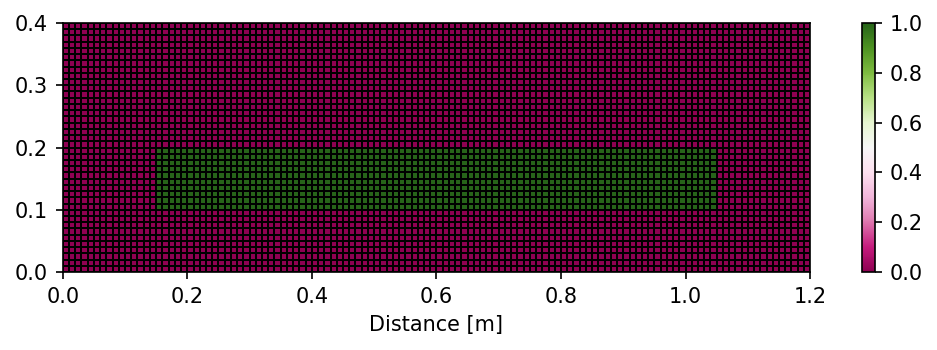

In [68]:
# Model discretization
nrow = 1 # 
nlay = 40
ncol = 120 
delr = 0.01 # [m] grid size in direction of X (J) axis
delc = 0.03 # grid size in direction of Y (I) axis, 
delv = 0.01 # grid size in direction of Z (K) axis

# start with zeros everywhere
material_location = np.zeros([nlay, nrow, ncol])
# index to apply clay to subvolume of model
material_location[10:20, :, 15:-15] = 1
# plot location of materials
plot_2d(np.squeeze(material_location), delr, delv, cmap='PiYG')

Now let's apply material properties

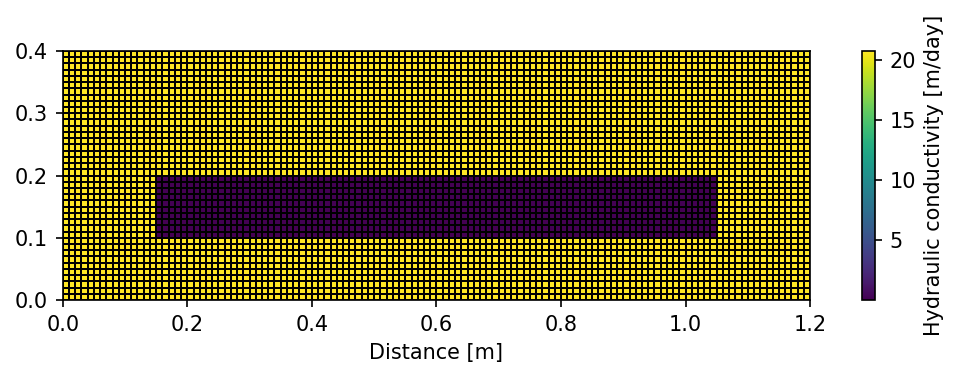

In [69]:
# unit converter
sec2day = 86400
# sand hydraulic conductivity
ksand = 2.4e-4*sec2day # [m/day]
# clay hydraulic conductivity
kclay = 1e-10*sec2day # [m/d]
# kclay = 1e-5*sec2day # [m/d]
# assign to matrix
Hk = np.ones([nlay, nrow, ncol])*ksand
Hk[material_location==1] = kclay

# double check that the stencil method is working
plot_2d(np.squeeze(Hk), delr, delv, cmap='viridis', colorbar_label='Hydraulic conductivity [m/day]')

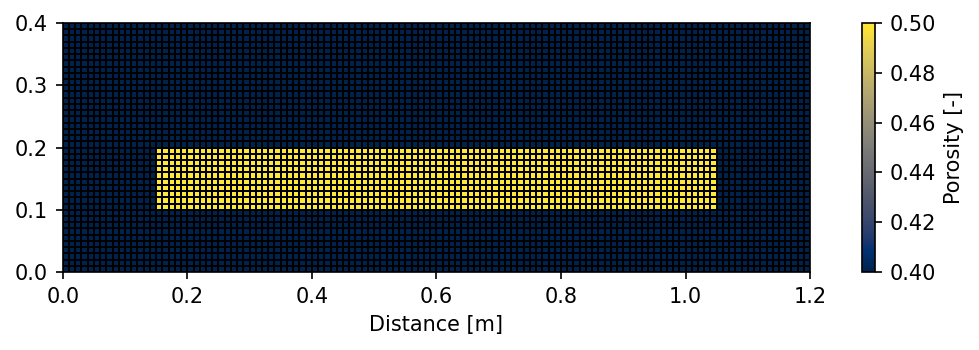

Tank pore volume 0.006030 m^3


In [70]:
# sand porosity
por_sand = 0.4
# clay porosity
por_clay = 0.5
# assign to matrix
Por = np.ones([nlay, nrow, ncol])*por_sand
Por[material_location==1] = por_clay
# Uncomment to plot porosity
plot_2d(np.squeeze(Por), delr, delv, colorbar_label='Porosity [-]')

# pore volume calculation
PV = Por*delr*delc*delv
tank_pv = np.sum(PV)
print('Tank pore volume %f m^3' %tank_pv)

## 2D Model Function with heterogenous porosity and hydraulic conductivity field
The next thing that we need to do is setup the model function. We will use similiar settings as the [FloPy 1D Function](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/FloPy%201D%20Function.ipynb), but we are expanding to two dimensions and using wells to inject on the left side of the model. The input variables are:

### Function Input:
#### directory name
    direname = 

#### MT3D period length (days)
The model time length is the sum of this (for steady state flow it can be set to anything). Note that in this function this will also apply to the MODFLOW flow model period input. The function is set up to allow any number of periods. For example:
 
    perlen_mt = [60, 12, 30]

#### hydraulic conductivity (meters/day)
The hydraulic conductivity needs to be input as a 3D matrix with the dimensions of the model. If you want to assign homogenous hydraulic conductivity then use the following line for defining the model hydraulic conductivity.
```python
Hk = homogeneous_hk_value *np.ones([nlay, nrow, ncol])
```
    
#### porosity (unitless)
The porosity can be a scalar or needs to be input as a 3D matrix with the dimensions of the model. 

    Por = 
    
#### injection rate in entire left side of model (cubic meters per day)
This is the source of the tracer and all water injected into the model using the Well Package.

    Q = 
    
#### injection concentration 
This is the concentration of the tracer injected into the left side of the model.

    Cinj = 
    
#### bulk diffusion coefficient
Keep in mind that the units for this model are meters and days.

    D0 = 
    
#### number of output steps for gridcell concentration data
An integer indicating the number of output times for concentration data.

    nprs = 
    
#### grid cell sizes (meters)
The following are the grid size in the x, y, and x axis respectively. This model is built to model flow in the x-z plane.

    delr = 
    delc = 
    delv = 
    

In [71]:
def model_2D(dirname, perlen_mt, Hk, Por, Q, Cinj, D0, nprs, delr, delc, delv):
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 4 # MODFLOW
    mt_tunit = 'D' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 2 # MODFLOW units
    mt_lunit = 'M' # MT3D units
    
    # Modflow stress periods, set MODFLOW and MT3D stress periods equal
    perlen_mf = perlen_mt
    # print(perlen_mf)
    # number of stress periods (MF input), calculated from period length input
    nper_mf = len(perlen_mf)
    
    # number of stress periods (MT input), calculated from period length input
    nper = len(perlen_mt)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = nprs
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # Model information 
    hk_size = Hk.shape
    nlay = hk_size[0] # number of layers
    nrow = hk_size[1] # number of rows
    ncol = hk_size[2] # number of columns
    botm = -np.linspace(delv, delv*nlay, nlay)
    # print(botm)
    
    # ADDITIONAL MATERIAL PROPERTIES
    al = 0.01 # longitudental dispersivity [m]
    trpv = 0.001/al # ratio of vertical transverse dispersivity to longitudenal dispersivity
    
    # Flow field boundary conditions
    # boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    # index the model boundary cells
    ibound[:, :, -1] = -1
    # initial head conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    
    # Stress period well data for MODFLOW. Each well is defined through defintition
    # of layer (int), row (int), column (int), flux (float). The first number corresponds to the stress period
    # Example for 1 stress period: spd_mf = {0:[[0, 0, 1, q],[0, 5, 1, q]]}
    # For Q, a positive value indicates recharge and a negative value indicates discharge (pumping).
    well_info = np.zeros((nlay, 4), dtype=float)
    # set indices of inlet face of column
    well_info[:,0] = range(0, nlay)
    # set volumetric flow rate
    well_info[:,3] = Q[0]/(nrow*nlay)
  
    # use copy.deepcopy (imported as 'deepcopy') to copy well_info array into dictonary
    # note that if this deepcopy isn't made then when the flow rate it updated
    # in well_info it will update all values copied to dictionary!
    w = deepcopy(well_info)
    # Now insert well information into the MODFLOW stress period data dictionary
    # This has the form: spd_mf = {0:[[0, 0, 0, q],[0, 5, 1, q]], 1:[[0, 1, 1, q]]}
    spd_mf={0:w}
    
    # iterate through the stress periods to updated the flow rate
    for i in range(1,nper):
        # print(q[i])
        if isinstance(Q, (list, tuple, np.ndarray)):
            well_info[:,3] = Q[i]/(nrow*nlay)
        else:
            well_info[:,3] = Q/(nrow*nlay)
            
        # deep copy and insert into MODFLOW well dictionary
        w = deepcopy(well_info)
        spd_mf.update({i:w})  

    # Solute transport boundary conditions
    # Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
    # If icbund < 0, the cell is a constant-concentration cell; 
    # If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
    icbund = np.ones((nlay, nrow, ncol), dtype=int)

    # Initial conditions: concentration zero everywhere
    sconc = np.zeros((nlay, nrow, ncol), dtype=float)
    
    # MT3D stress period data, note that the indices between 'spd_mt' must exist in 'spd_mf' 
    # This is used as input for the source and sink mixing package
    # Itype is an integer indicating the type of point source, 2=well, 3=drain, -1=constant concentration
    itype = 2
    cwell_info = np.zeros((int(nlay), 5), dtype=float) # Note each cell list is one longer because itype is included with each entry: [layer, row, col, C_in[i], itype] 
    cwell_info[:,0] = range(0, nlay)
    cwell_info[:,3] = Cinj[0]
    # assign itype
    cwell_info[:,4] = int(itype)
    # insert into MT3D well dictionary
    cw = deepcopy(cwell_info)
    spd_mt = {0:cw}
    
    # iterate through the stress periods to updated the concentration injected
    for i in range(1,nper):
        # This if statement provides flexibility in the model if the user wants to keep the concentration injected constant throughout the model run
        if isinstance(Cinj, (list, tuple, np.ndarray)):
            cwell_info[:,3] = Cinj[i]
        else:
            cwell_info[:,3] = Cinj
            
        # deep copy and insert into MT3D well dictionary
        cw = deepcopy(cwell_info)
        spd_mt.update({i:cw})  
    
    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # MODFLOW package class
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper_mf,
                                   delr=delr, delc=delc, top=0., botm = botm,
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class 
    # laytpe=0 is default and sets to be confined
    lpf = flopy.modflow.ModflowLpf(mf, hk=Hk, laytyp=0)
    # MODFLOW well package class
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=spd_mf)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf, rclose=1.0e-5, mxiter=100, iter1=50)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    # MODFLOW output control package ##### NEEDS TO BE INCLUDED TO EXTRACT HEADS ###########
    spd = {(0, 0): ['save head'], (0, 1): ['save head'], (0, 2): ['save head'], (0, 3): ['save head']}
    oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS Model Class
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=Por, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nper=nper, 
                             perlen=perlen_mt, nprs=nprs, timprs=timprs)
    
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this seems to result in minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = -1
    
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpv =trpv, dmcoef=D0)
    
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, x, y, z)
    conc = ucnobj.get_alldata()
    
    # Extract head information. In order for this to work you must include 'oc = flopy.modflow.ModflowOc(mf)' before running mf model
    # if you pass the model instance, then the plots will be offset and rotated
    h = flopy.utils.HeadFile(os.path.join(model_ws, modelname_mf+'.hds'), model=mf)
    htimes = h.times
    fname = os.path.join(model_ws, modelname_mf+'.hds')
    hdobj = flopy.utils.HeadFile(fname)
    heads = hdobj.get_data()
    
    if len(times) != nprs+len(perlen_mt):
        print('The model output has {} timesteps, the model input requested {} timesteps. Simulation may have terminated early'.format(len(times), nprs+len(perlen_mt)))
    else:
        print('Simulation ran to requested model time.')
    
    return heads, htimes, conc, times

## Run numerical models

Ok, now we are ready to run some models! Let's first run the model with the heterogeneous permeability field that we plotted above.

In [59]:
# Directory name
dirname = 'Chapman_model'
# Length of model run
perlen_mt = [10, 22, 50]
# number of model output times
nprs = 165

# scale factor based on height of model relative to tank in Chapman paper
sf = nlay*delv/0.84
Q = np.array([0.9, 1.5, 1.5])*(60*24/100**3)*sf #[m^3/day]
Cinj = [1, 0, 0]
# Bulk diffusion coefficient
D0 = 13E-10*sec2day # [m^2/day]

In [72]:
heads, htimes, conc, times = model_2D(dirname, perlen_mt, Hk, Por, Q, Cinj, D0, nprs, delr, delc, delv)

.\backdiff\Chapman_model
Simulation ran to requested model time.


Let's first look at the heads to see how the head compares with the hydraulic conductivity field.

(40, 1, 120)


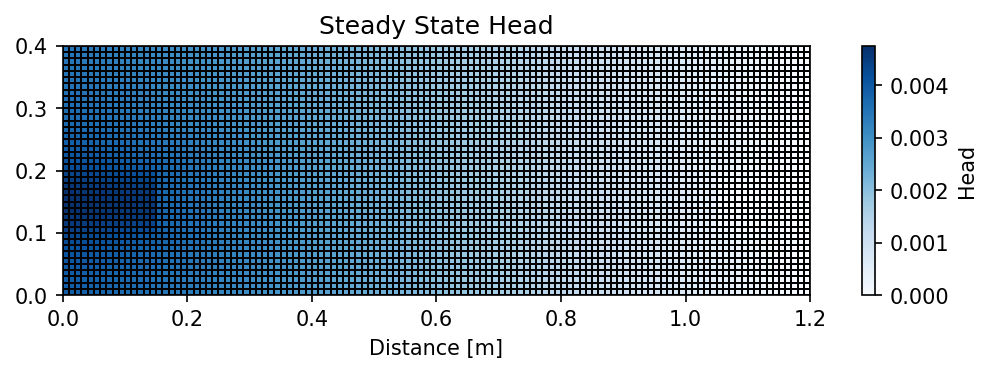

In [73]:
print(heads.shape)
plot_2d(np.squeeze(heads), delr, delv, colorbar_label='Head', cmap='Blues', title='Steady State Head')

Now let's look at some 2D concentration maps to get a better sense of where the solute is moving in the system and when.

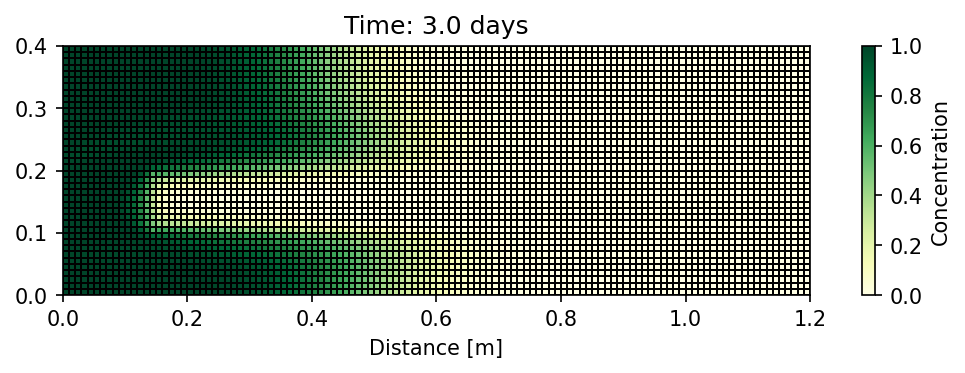

In [74]:
# Let's check your answer
ts_plot = 6
# double check that the stencil method is working (map_data, dx, dy, colorbar_label='', cmap='cividis', title='')
plot_2d(np.squeeze(conc[ts_plot,:,:,:]), delr, delv, colorbar_label='Concentration', cmap='YlGn', title='Time: %1.1f days' %(times[ts_plot]), clim=[0,1])

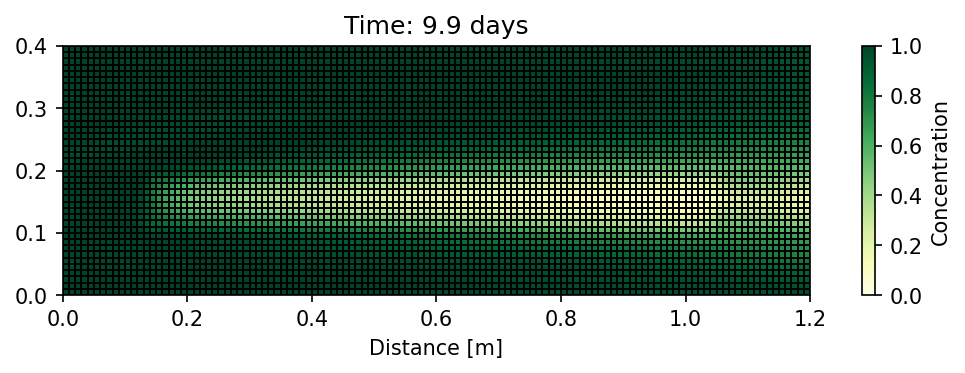

In [75]:
ts_plot = 20
# double check that the stencil method is working (map_data, dx, dy, colorbar_label='', cmap='cividis', title='')
plot_2d(np.squeeze(conc[ts_plot,:,:,:]), delr, delv, colorbar_label='Concentration', cmap='YlGn', title='Time: %1.1f days' %(times[ts_plot]), clim=[0,1])

Notice how we don't have much advection through the clay layer? The transport into this layer is largely diffusive.

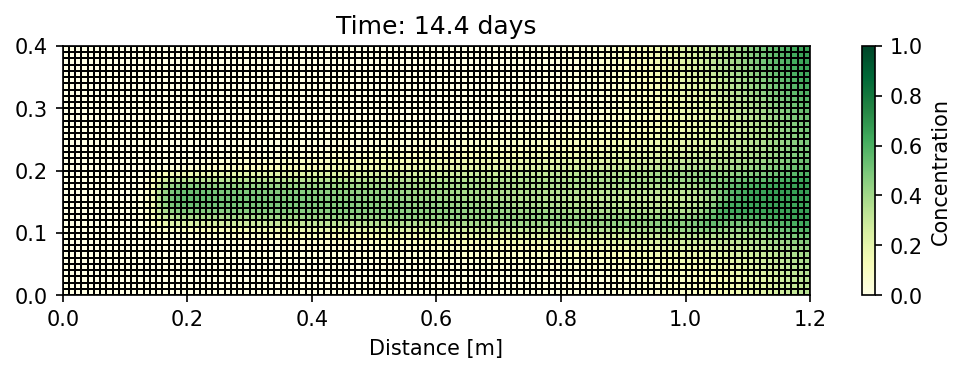

In [76]:
ts_plot = 30
# double check that the stencil method is working (map_data, dx, dy, colorbar_label='', cmap='cividis', title='')
plot_2d(np.squeeze(conc[ts_plot,:,:,:]), delr, delv, colorbar_label='Concentration', cmap='YlGn', title='Time: %1.1f days' %(times[ts_plot]), clim=[0,1])

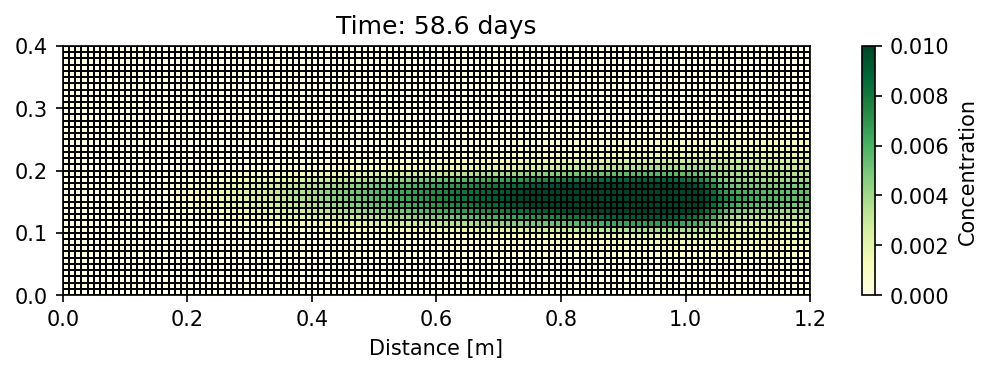

In [77]:
# Let's look at the end of the model
ts_plot = 120
# double check that the stencil method is working (map_data, dx, dy, colorbar_label='', cmap='cividis', title='')
plot_2d(np.squeeze(conc[ts_plot,:,:,:]), delr, delv, colorbar_label='Concentration', cmap='YlGn', title='Time: %1.1f days' %(times[ts_plot]), clim=[0,0.01])

Explain what is going on here. Why is there still solute stuck in the clay layer after 60 days of pumping? Note that the difference in colorscale. 

### Breakthrough curves
Now let's take a look at what the breakthrough curves look like.

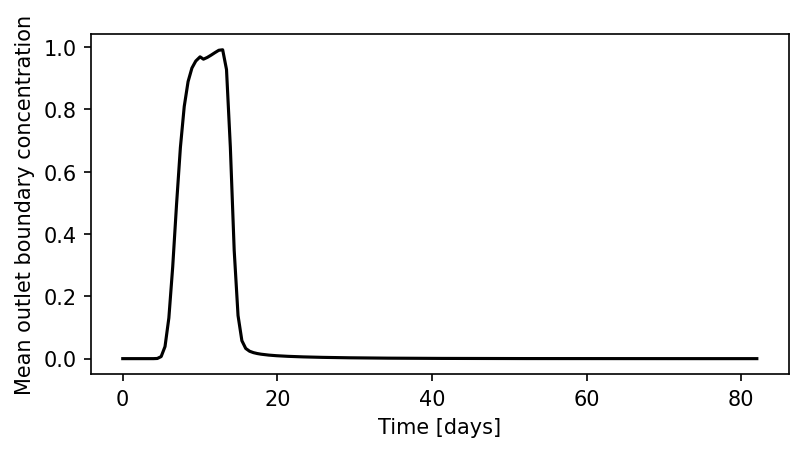

In [78]:
# Extract the breakthrough time at the outlet
C_btc_model = np.mean([conc[:, 0, :, -1]], axis=2)
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(times, np.transpose(C_btc_model), 'k', label='')
plt.xlabel('Time [days]');
plt.ylabel('Mean outlet boundary concentration')
plt.show()

It doesn't look like much is happening! How about plotting the concentration on a log scale.

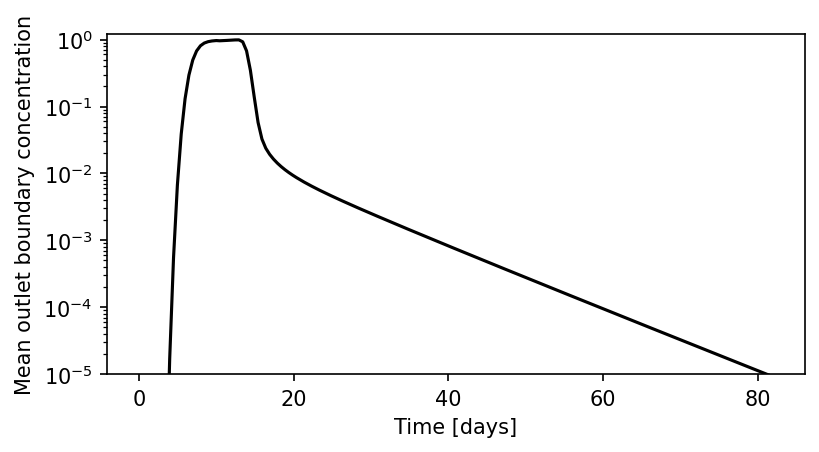

In [79]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(times, np.transpose(C_btc_model), 'k', label='')
plt.yscale('log')
plt.xlabel('Time [days]');
plt.ylabel('Mean outlet boundary concentration')
plt.ylim([1E-5, 1.2])
plt.show()

From the plot above we can see that there is some long-term transport of solute as it is diffused from the clay layer. This effect is often termed 'tailing'. However, this isn't obvious when looking at the BTC on a linear axis. This illustrates the importance of analyzing some contaminant BTCs on a log axis when we are dealing with contaminants that have a very low maximum contaminant level (MCL) and where the concentration in the environment can vary by orders of magnitude.

## Activity:
You might be asking why we used such a fine discretization for the above model. Can we make it coarser? Let's exlore!

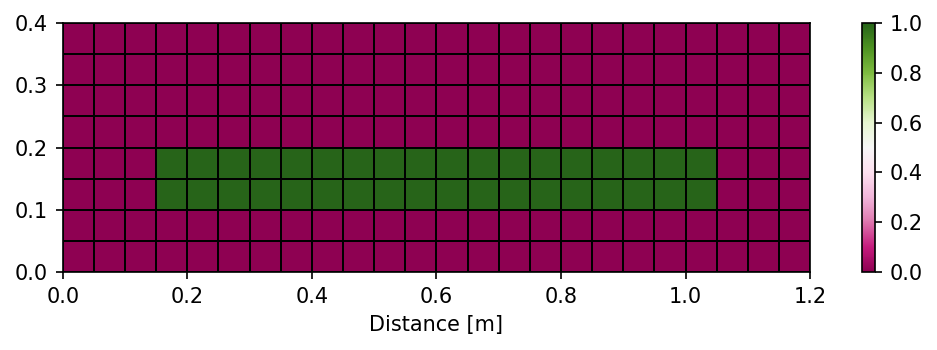

In [80]:
# Model discretization
nrow = 1 # 
nlay = 8
ncol = 24 
delr = 0.05 # [m] grid size in direction of X (J) axis
delc = 0.03 # grid size in direction of Y (I) axis, 
delv = 0.05 # grid size in direction of Z (K) axis

# start with zeros everywhere
material_location = np.zeros([nlay, nrow, ncol])
# index to apply clay to subvolume of model
material_location[2:4, :, 3:-3] = 1
# plot location of materials
plot_2d(np.squeeze(material_location), delr, delv, cmap='PiYG')

# build Hk matrix
Hk = np.ones([nlay, nrow, ncol])*ksand
Hk[material_location==1] = kclay

# build porosity to matrix
Por = np.ones([nlay, nrow, ncol])*por_sand
Por[material_location==1] = por_clay

In [81]:
# Directory name
dirname = 'Chapman_model_coarse'
heads_c, htimes_c, conc_c, times_c = model_2D(dirname, perlen_mt, Hk, Por, Q, Cinj, D0, nprs, delr, delc, delv)

.\backdiff\Chapman_model_coarse
Simulation ran to requested model time.


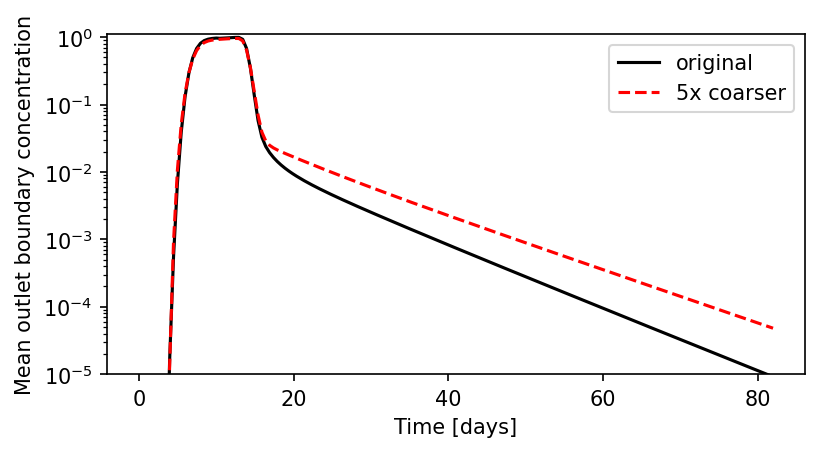

In [82]:
C_btc_model_c = np.mean([conc_c[:, 0, :, -1]], axis=2)
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(times, np.transpose(C_btc_model), 'k', label='original')
plt.plot(times_c, np.transpose(C_btc_model_c), '--r', label='5x coarser')
plt.legend()
plt.yscale('log')
plt.xlabel('Time [days]');
plt.ylabel('Mean outlet boundary concentration')
plt.ylim([1E-5, 1.1])
plt.show()

Well, we got two different answers. When this happens we have a few different options. The first is to compare with analytical solutions as we have done with 1D systems. In this case, we would need to further similify the model to find an analytical solution for comparison (for example have a two layer model). An alternative option is to further refine the grid to determine the grid resolution necessary to obtain a solution that coverges, or essentially stops changing as the grid cells get smaller. Note that this method can get computatially intesive if the model domain is too large.

Give this a shot by reducing the original grid cell size by only half.

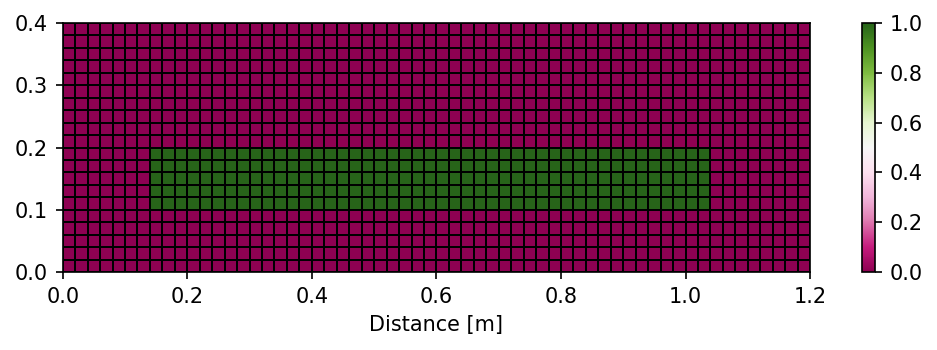

In [83]:
# Model discretization
nrow = 1 # 
nlay = 20
ncol = 60
delr = 0.01*2 # [m] grid size in direction of X (J) axis
delc = 0.03 # grid size in direction of Y (I) axis, 
delv = 0.01*2 # grid size in direction of Z (K) axis

# start with zeros everywhere
material_location = np.zeros([nlay, nrow, ncol])
# index to apply clay to subvolume of model
# material_location[10:20, :, 15:-15] = 1
material_location[5:10, :, 7:-8] = 1
# plot location of materials
plot_2d(np.squeeze(material_location), delr, delv, cmap='PiYG')

# build Hk matrix
Hk = np.ones([nlay, nrow, ncol])*ksand
Hk[material_location==1] = kclay

# build porosity to matrix
Por = np.ones([nlay, nrow, ncol])*por_sand
Por[material_location==1] = por_clay

In [84]:
# Directory name
dirname = 'Chapman_model_med'
heads_m, htimes_m, conc_m, times_m = model_2D(dirname, perlen_mt, Hk, Por, Q, Cinj, D0, nprs, delr, delc, delv)

.\backdiff\Chapman_model_med
Simulation ran to requested model time.


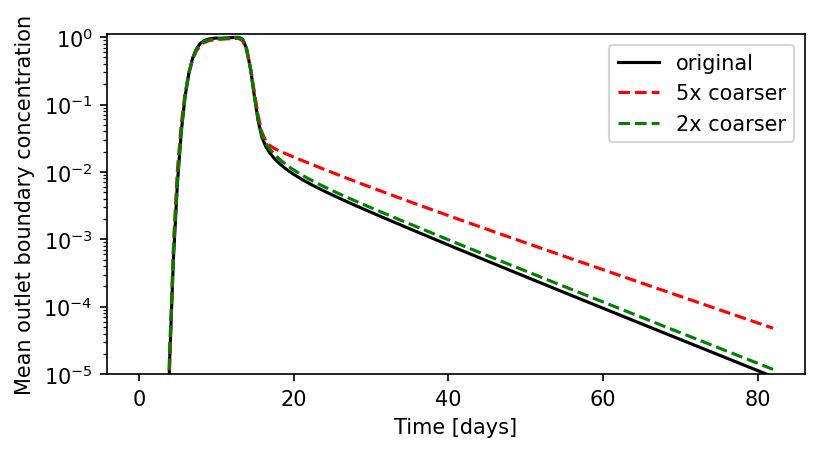

In [85]:
C_btc_model_m = np.mean([conc_m[:, 0, :, -1]], axis=2)
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(times, np.transpose(C_btc_model), 'k', label='original')
plt.plot(times_c, np.transpose(C_btc_model_c), '--r', label='5x coarser')
plt.plot(times_m, np.transpose(C_btc_model_m), '--g', label='2x coarser')
plt.legend()
plt.yscale('log')
plt.xlabel('Time [days]');
plt.ylabel('Mean outlet boundary concentration')
plt.ylim([1E-5, 1.1])
plt.show()

We can see that going a little coarser still captures most of the tailing behavior and therefore is probably sufficient.

With a partner, discuss these results. Why do you think the grid cells have to be so small when modeling diffusion-dominated transport processes? What limitations does this present for modeling back diffusion or other field-scale diffusion processes?